# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [160]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import datetime

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [86]:
%matplotlib inline

In [155]:
# https://matplotlib.org/examples/pylab_examples/centered_ticklabels.html
# https://stackoverflow.com/questions/46555819/months-as-axis-ticks
# https://stackoverflow.com/questions/36010999/convert-pandas-datetime-month-to-string-representation

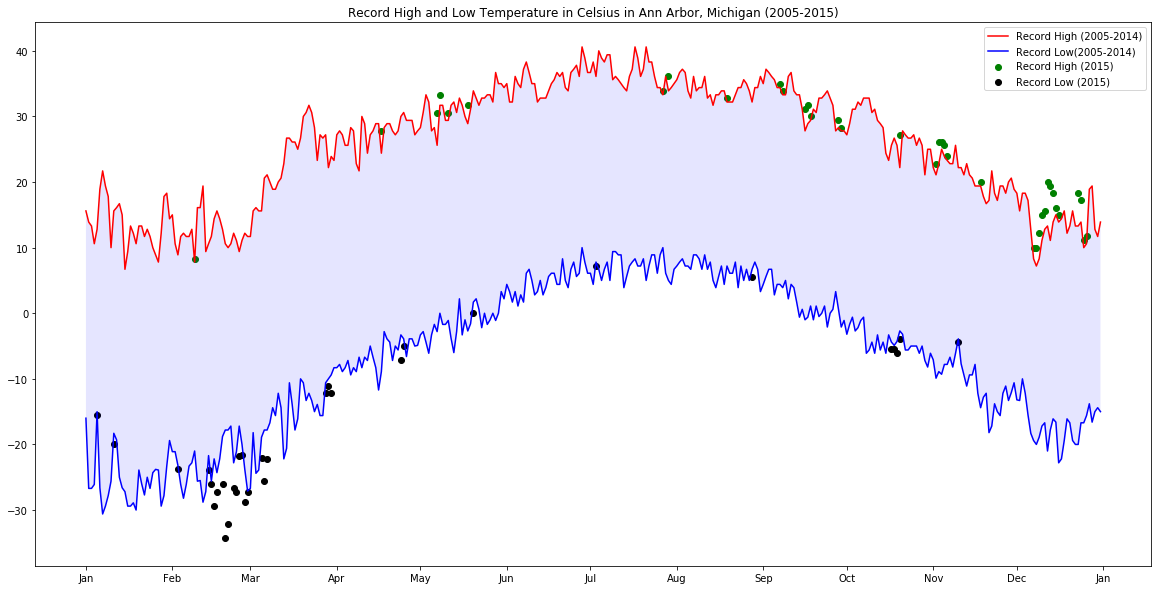

In [167]:
#----cleaning/formatting data------

# grab data for Ann Arbor, Michigan
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

# temp is in degrees of tenths of degrees C, which means a decimal point was not included
# clean up data by dividing by 10
df['Data_Value'] = df['Data_Value']/10

# create a new month column by extracting month from the Date column. Convert to string and pad to two digits
df['month'] = pd.DatetimeIndex(df['Date']).month
df['month_str'] = df.month.map("{:02}".format)

# create a new month column by extracting day from the Date column. Convert to string and pad to two digits
df['day'] = pd.DatetimeIndex(df['Date']).day
df['day_str'] = df.day.map("{:02}".format)

# concatenate month and day into new column
df['month_day'] = df['month_str'] + df['day_str']


#----- 2014 data--------

# create new df to include only dates from 2005 - 2014
newdf = df[df['Date']<'2015-01-01']
newdf = newdf.sort_values('Date')

# add in placeholder year column
newdf['year'] = 2014

# group the data by the month_day and datetime columns and calculate min and max temp
finaldf = newdf.groupby(['month_day', 'year', 'month', 'day'])['Data_Value'].agg([np.max, np.min])
finaldf.reset_index(inplace=True)
finaldf = finaldf.sort_values('month_day')

# drop leap year day (Feb 29th)
plotdf = finaldf[finaldf.month_day != '0229'].copy()

# create new column with datetime value
plotdf['new_date'] = plotdf.apply(lambda x: datetime.date(x['year'], x['month'], x['day']), axis=1)
plotdf = plotdf.set_index('new_date')


#----- 2015 data--------

# create a new df for 2015 data. Add placeholder 2014 year
df_2015 = df[df['Date']>='2015-01-01']
df_2015 = df_2015.sort_values('Date')
df_2015['year'] = 2014

# group the data by the month_day and datetime columns and calculate min and max temp
df_2015_group = df_2015.groupby(['month_day', 'year', 'month', 'day'])['Data_Value'].agg([np.max, np.min])
df_2015_group.reset_index(inplace=True)
df_2015_group = df_2015_group.sort_values('month_day')

# drop leap year day (Feb 29th)
final_2015 = df_2015_group[df_2015_group.month_day != '0229'].copy()

# create new column with datetime value
final_2015['new_date']= final_2015.apply(lambda x: datetime.date(x['year'], x['month'], x['day']), axis=1)
final_2015 = final_2015.set_index('new_date')

# compare 2015 data to 2005 - 2014 data to find record highs and lows
final_2015['record_high'] = np.where(plotdf['amax'] < final_2015['amax'], 'True', 'False')
final_2015['record_low'] = np.where(plotdf['amin'] > final_2015['amin'], 'True', 'False')

# create new dfs for record highs and lows in 2015
plot_highs = final_2015[final_2015['record_high']=='True']
plot_lows = final_2015[final_2015['record_low']=='True']


#-----plotting------

# create the figure and plot data
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(plotdf.index, plotdf.amax, '-r')
ax.plot(plotdf.index, plotdf.amin, '-b')
ax.scatter(plot_highs.index, plot_highs.amax, color='green')
ax.scatter(plot_lows.index, plot_lows.amin, color='black')

ax.legend(['Record High (2005-2014)', 'Record Low(2005-2014)', 'Record High (2015)', 'Record Low (2015)'])

# set custom xaxis with month names
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))

# fill in area between max and min temps
plt.gca().fill_between(plotdf.index, plotdf.amax, plotdf.amin, facecolor='blue', alpha=0.10)

# set axes labels and chart title
ax.set_title('Record High and Low Temperature in Celsius in Ann Arbor, Michigan (2005-2015)')

plt.show()